# 量子コンピューティング1A Basics 3　演習
## 量子探索アルゴリズムとボードゲームソルバ

今回の演習では、前回理論的基礎を扱ったグローバーのアルゴリズムを用いてボードゲームソルバを作ります。

In [ ]:
# 1
! pip install qiskit[visualization]
! pip install qiskit-ibm-runtime
! pip install qiskit-aer

## 復習
補助量子ビットを用いたGroverのアルゴリズム

In [2]:
# 2
# 各種ライブラリをimportします
import matplotlib.pyplot as plt
import numpy as np
import random

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import MCXGate

In [3]:
# 3
def run_qc_on_aer(qc):
  simulator = AerSimulator()
  compiled_circuit = transpile(qc, simulator)
  result = simulator.run(compiled_circuit).result()
  counts = result.get_counts()
  return counts

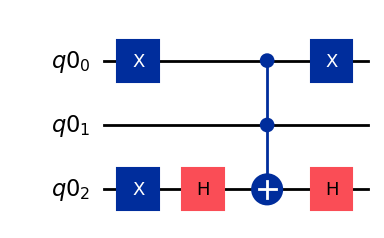

In [4]:
# 4
def phase_oracle(circuit, register,oracle_register):
    circuit.h(oracle_register)
    circuit.x(register[0])
    circuit.ccx(register[0], register[1],oracle_register)
    circuit.x(register[0])
    circuit.h(oracle_register)

qr = QuantumRegister(3)
oracleCircuit = QuantumCircuit(qr)
oracleCircuit.x(qr[2])
phase_oracle(oracleCircuit, qr,qr[2])
oracleCircuit.draw(output="mpl")

In [5]:
 # 5
def inversion_about_average(circuit, register):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[1])
    circuit.cx(register[0], register[1])
    circuit.h(register[1])
    circuit.x(register)
    circuit.h(register)

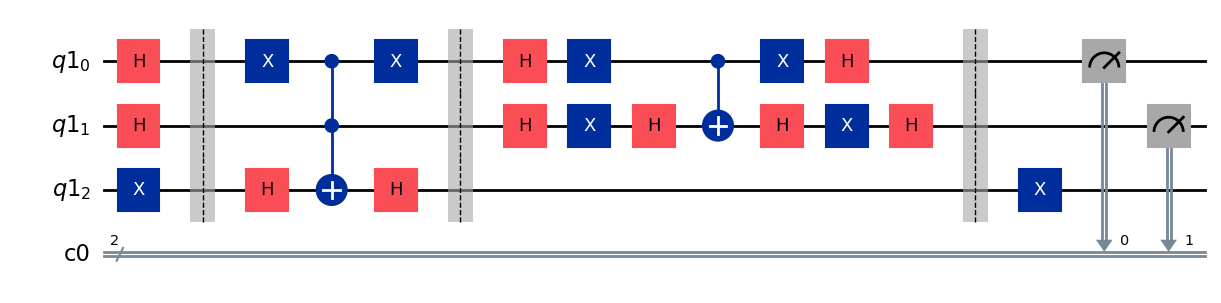

In [6]:
# 6
qr = QuantumRegister(3)
cr = ClassicalRegister(2)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr[0:2])
groverCircuit.x(qr[2])
groverCircuit.barrier()
phase_oracle(groverCircuit, qr,qr[2])
groverCircuit.barrier()
inversion_about_average(groverCircuit, qr[0:2])
groverCircuit.barrier()
groverCircuit.x(qr[2]) # 補助量子ビットの値を元に戻す
groverCircuit.measure(qr[0],cr[0])
groverCircuit.measure(qr[1],cr[1])
groverCircuit.draw(output="mpl")

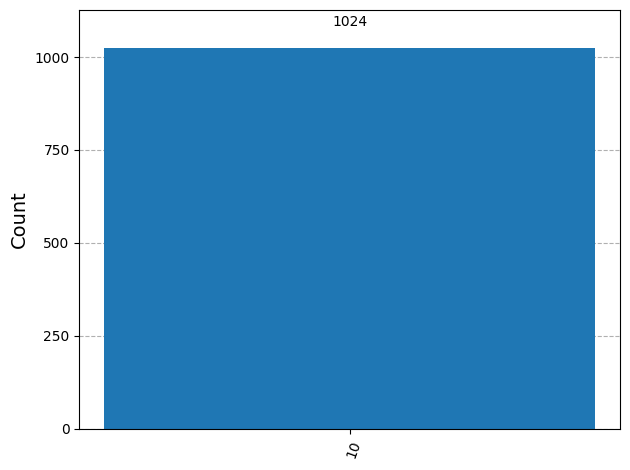

In [7]:
# 7
count = run_qc_on_aer(groverCircuit)
plot_histogram(count) 

# ライツアウト パズル

ライツアウトは有名なパズルゲームです。プレーヤーに格子状に並べられたライトが与えられます。このうちいくつかは点灯しており、いくつかは消灯しています。この問題の目的は、ライトを全て消灯させることです。各ライトにはスイッチがついており、それを押すことで点灯/消灯させることができます。しかしながらこのライトは少し特殊で、あるライトのスイッチを押すと、連動して上下左右の隣接したライトの状態も切り替わってしまいます。

## 例題
以下の図は、3x3のライツアウトパズルの例です。各ライトには0から8までのラベルが付いています。バイナリのリストを使用して与えられた盤面を表すことができます。`1`はオンになっているライトを表し、`0`はオフになっているライトを表します。以下のリスト(`lights`)は、この例の初期盤面を表しています（ライト 3、5、6、7がオンで、残りはオフです）。

```python
lights = [0, 0, 0, 1, 0, 1, 1, 1, 0]
```

例題は、図で示されているように、0、3、4のスイッチを操作することで解決できます。少し遊んでみると、すぐにこのパズルゲームの**2つの重要な特性**に気付くでしょう。
1. 同じスイッチを複数回押す必要はありません。
2. スイッチを押す順序は特に意味を持ちません。

従って、初期の盤面同様にバイナリのリストでパズルの解を表現できます。 ただし、ここでは`0`と`1`の意味が盤面のそれと異なります。`1`はスイッチを切り替えることを表し、`0`はスイッチを切り替えないことを表します。

```python
solution = [1, 0, 0, 1, 1, 0, 0, 0, 0]
```
<img src="./fig/lights_out_rule.png" width="700">

In [8]:
# 8
# ライツアウトの盤面生成と可視化
def visualize_lights_out(board_vec):
    if len(board_vec) != 9:
        raise ValueError("Input must be a list or array of length 9.")
    # 3x3に変換
    print('Board:\n', board_vec)
    board = np.array(board_vec).reshape((3, 3))
    # カラーマッピング
    color_map = {0: 'gray', 1: '#FF69B4'}  # gray for 0, fluorescent pink for 1
    fig, ax = plt.subplots(figsize=(3, 3))
    gap = 0.15  # 隙間の幅
    for i in range(3):
        for j in range(3):
            rect = plt.Rectangle((j + gap/2, 2 - i + gap/2), 1 - gap, 1 - gap,
                                  facecolor=color_map[board[i, j]], edgecolor='black')
            ax.add_patch(rect)

    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()

def apply_move(board, move):
    # ボタンの押し方に応じて盤面を更新する（あるボタンを押すと、押したボタンと隣接するボタンが反転する）
    toggle_indices = [
        [0, 1, 3],
        [0, 1, 2, 4],
        [1, 2, 5],
        [0, 3, 4, 6],
        [1, 3, 4, 5, 7],
        [2, 4, 5, 8],
        [3, 6, 7],
        [4, 6, 7, 8],
        [5, 7, 8]
    ]
    for idx, pressed in enumerate(move):
        if pressed:
            for t in toggle_indices[idx]:
                board[t] ^= 1
    return board

def generate_random_board():
    # 全て消灯の盤面からスタート
    board = [0] * 9
    # ランダムなボタン押下パターンを作成
    move = [random.randint(0, 1) for _ in range(9)]
    # 適用
    board = apply_move(board, move)
    return board

Board:
 [0, 1, 0, 1, 1, 0, 1, 1, 0]


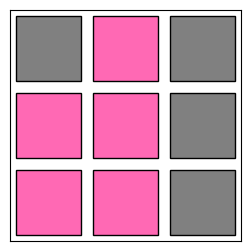

In [9]:
# 9
# 使用例
random_board = generate_random_board()
visualize_lights_out(random_board)

Board:
 [0, 0, 0, 0, 0, 0, 1, 0, 0]


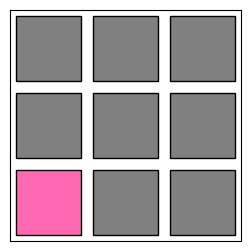

In [10]:
# 10
move = [1, 0, 0, 1, 0, 0, 1, 0, 0]  # ボタンを押すパターン
push_board = apply_move(random_board, move)
visualize_lights_out(random_board)

# 演習
これまでの講義で学んだことをいかして、ライツアウトを**Groverのアルゴリズム**を使って解いてみましょう！

以下の盤面を解くための量子回路を作成してください。提出する量子回路では、パズルの答えとなる**`solution`(9bit)のみを観測してください。**
提出形式は、lightsを引数とし、`QuantumCircuit`を返す関数です（関数名は任意のものを付けて問題ありません）。異なる入力(lights)でも問題が解ける関数にしてください。異なる入力で検証を行います。

**尚、量子回路は 28 qubits 以内で実装してください。**

説明で用いられているものと同じエンディアンで解答が得られるようになっているか注意してください。以下の関数を使っても構いません。

```python
qc = qc.reverse_bits()
```

また、`lights`を`tile`レジスタにマップする関数`map_board`を用意しておきます。

In [ ]:
# 11
def map_board(lights, qc, qr):
    j = 0
    for i in lights:
        if i==1:
            qc.x(qr[j])
            j+=1
        else:
            j+=1

## ヒント  
この問題を解くには複雑なオラクルが必要になるでしょう。補助量子ビットを追加することでオラクル部分の設計が容易になりますが、その取り扱いには注意が必要です。オラクル部分の終了時点では全ての補助量子ビットが初期状態に戻っている必要があります（この操作はUncomputationと呼ばれることもあります）。  

補助量子ビットを|-> ではなく|0>に初期化しておき、補助量子ビットをZ測定することでオラクルをユニットテストできます。

In [ ]:
# 12
# 初期状態は以下のリストで与えられます。 
# 回路の入力としてお使いください。
lights = [0,1,0,1,1,0,0,1,1]

ナイーブにこの問題をグローバーで解こうとすると、以下のような回路が必要です。
<img src="./fig/lightsout-circuit.jpeg" width="700">

ここで、
* `tile` レジスタはライトの盤面の状態を表現するために使用します。
* `flip`レジスタはどのスイッチを押すのかを表現します。
* `oracle`レジスタは全てのライトを消灯できる解をマークするために使用します。
* `auxiliary`レジスタはMCTゲート(control qubitが複数のCXゲート)の量子コストを減らすために使用します(このレジスタがなくても問題を解くことができます)。
* `result`レジスタは、解を格納するための古典レジスタです。

しかし、このままでは多くの量子ビットが必要になります。問題の古典的な性質を使って探索空間を小さくすることを考えてみましょう。

解の最も上の行(3ビット)を固定すると、プレイヤーが押すべき解(残りの6ビット)は一意に定まるという性質があります(あるいは、その3ビットを含むパターンでは問が解けないとわかります)。これは、以下からわかります。

* $n$行目のスイッチを押下したあとに$n$行目のライトで点灯しているものが残っていた場合、$n+1$行目のスイッチで必ず消さなければ全消灯できない($n+1$行目の解が固定される)。

<img src="./fig/lightsout-searching-space.png" width="700">

この性質を用いることで、探索空間は$2^3$に抑えられます(Groverの繰り返し回数も減らすことができます)。最も上の行の3qubitのみを重ね合わせとして用意します。

<img src="./fig/lightsout-opt-circuit.jpg" width="700">

最初に示した解法では、`flip`関数は単純に解候補を入力としていました。ここでは、解の最も上の行の3bitを入力として、解空間(`flip`)と盤面(`tile`)を相互に作用させることで解を求めます。

* `flip_1`関数は、最も上の行の3ビットの解候補を入力として盤面(1行目と2行目)を変化させます

これを実行すると、残りの6bitの解で消さなければならないライトが残ります。

* `inv_1`関数は、flip関数とは対照的に、`tile`から`flip`への操作です。 `flip_1`を適用した後に消灯できなかった1行目のライトは、2行目の真下のボタンを押すことで消灯できます。従って、`tile`に残された1行目のライトの状態をそのまま2行目の解にmapします。

* `flip_2`（`flip_3`）関数は、`inv_1`(`inv_2`)によって決定される2行目（3行目）の解に基づいてボタンを押します。

* `inv_1`と同様に、`inv_2`関数は1行目と2行目の解を使用して3行目の解を決定します。

* `lights_out_oracle`は、ここまでの関数で決定された解候補を入力した後、すべてのライトがオフになっている場合にマーキングするオラクルです。このとき、最も下の行のライトがオフになっているかどうかを確認するだけで、すべてのライトがオフになっているかどうかを確認できます。これは、`inv_1`と`inv_2`によって`flip`内の解候補が1行目と2行目のライトを消灯させるものになっているからです。

解の最も上の行のみを重ね合わせとして用意するので、Groverのアルゴリズムで探索する空間は$2^3$です。`diffusion`(平均についての反転)は0, 1, 2番目の量子ビットのみを対象とすれば良いことに注意してください。

In [ ]:
# 13
tile = QuantumRegister(9)
flip = QuantumRegister(9)
oracle = QuantumRegister(1)
auxiliary = QuantumRegister(1)
result = ClassicalRegister(9)
# 20 qubit
qc = QuantumCircuit(tile, flip, oracle, auxiliary, result)

In [ ]:
# 14
def initialize_smart(l,qc,tile):
    map_board(l, qc, tile)
    qc.h(flip[:3])
    qc.x(oracle[0])
    qc.h(oracle[0])

def flip_1(qc,flip,tile):
    # push 0　
    qc.cx(flip[0], tile[0])
    qc.cx(flip[0], tile[1])
    qc.cx(flip[0], tile[3])
    # 以下を完成させてください
    # push 1　
    # push 2
    
def inv_1(qc,flip,tile):
    # copy 0,1,2
    # 以下を完成させてください
    
def flip_2(qc,flip,tile):
    # apply flip[3,4,5]
    # 以下を完成させてください
    
def inv_2(qc,flip,tile1):
    # copy 3,4,5
    # 以下を完成させてください
    
def flip_3(qc,flip,tile):
    # 以下を完成させてください

def lights_out_oracle(qc,tile,oracle,auxiliary):
    qc.x(tile[6:9])
    qc.mct(tile[6:9], oracle[0], auxiliary, mode='basic')
    qc.x(tile[6:9])
    
def diffusion(qc,flip):
    # 以下を完成させてください

In [ ]:
# 15
# 上の関数を完成させてから実行してください
initialize_smart(lights,qc,tile)

num_iterations = 1

for i in range(num_iterations):
    flip_1(qc,flip,tile)
    inv_1(qc,flip,tile)
    flip_2(qc,flip,tile)
    inv_2(qc,flip,tile)
    flip_3(qc,flip,tile)
    
    lights_out_oracle(qc,tile,oracle,auxiliary)
    
    flip_3(qc,flip,tile)
    inv_2(qc,flip,tile)
    flip_2(qc,flip,tile)
    inv_1(qc,flip,tile)
    flip_1(qc,flip,tile)
    
    diffusion(qc,flip)
    
# Uncompute
qc.h(oracle[0])
qc.x(oracle[0])

# 解の最も上の行から解全体を求める
# 解を得た後に盤面を初期化する必要はありません。従って、flip_3関数は必要ありません。
flip_1(qc,flip,tile)
inv_1(qc,flip,tile)
flip_2(qc,flip,tile)
inv_2(qc,flip,tile)

# 測定
qc.measure(flip,result)

# 出力のビットの順番が問と同じようになるように反転させます。
qc = qc.reverse_bits() 

In [ ]:
# 16
count = run_qc_on_aer(qc=qc)

In [ ]:
# 17
plot_histogram(count) 

In [ ]:
# 18
score_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)
final_score = score_sorted[0:40]
final_score

In [ ]:
# 19
# リストに変換
pattern = list(map(int, final_score[0][0]))
pattern

In [ ]:
# 20
#  最終スコアで最も測定回数の多いものをボードに適用して消灯するか確かめてください。
def check_answer(lights, move):
    board = apply_move(lights, move)
    # 盤面が全て消灯しているか確認
    correct_pattern = False
    if all(x == 0 for x in board):
        print("All lights are off!")
        correct_pattern = True
    else:
        print("Some lights are still on.")
    return correct_pattern

In [ ]:
# 21
check_answer(lights, pattern)

All lights are off!


True